# Introduction
We present AstroCLiP, a strategy to facilitate the construction of astronomical foundation models that bridge the gap between diverse astronomical observational modalities. We demonstrate that a cross-modal contrastive learning approach between images and spectra of galaxies yields highly informative embeddings of both modalities. In particular, we apply our method on multi-band images and spectrograms from the Dark Energy Spectroscopic Instrument (DESI), and show that: (1) these embeddings are well-aligned between modalities and can be used for accurate cross-modal searches, and (2) these embeddings encode valuable physical information about the galaxies - in particular redshift and stellar mass - that can be used to achieve competitive zero- and few- shot predictions without further finetuning. Additionally, in the process of developing our approach, we also construct a novel, transformer-based model and pretraining approach for galaxy spectra.

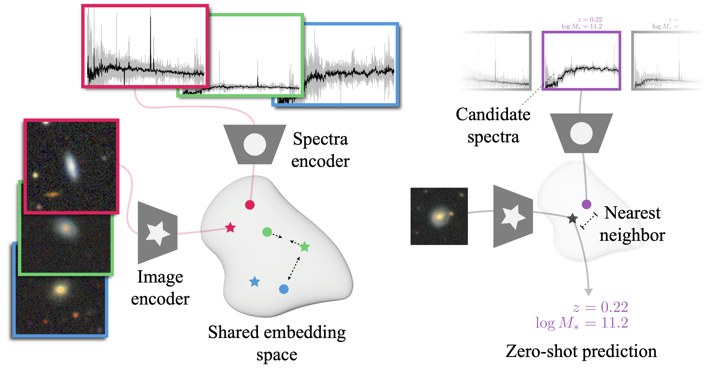

In [1]:
from IPython.display import Image, display
from PIL import Image as PILImage
image_path = "astro_clip_v3.png"  # Replace with your image file path
original_image = PILImage.open(image_path)
original_width, original_height = original_image.size
new_width = int(original_width * 0.25)
new_height = int(original_height * 0.25)
new_size = (new_width, new_height)
resized_image = original_image.resize(new_size)
resized_image

# Dependencies

In [29]:
%pylab inline

from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics.pairwise import cosine_similarity
from tutorial_helpers import load_model_from_ckpt, forward, slice, fnc, dr2_rgb, scatter_plot_as_images
import lightning as L
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision.models as models
from datasets import load_dataset
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomRotation, RandomErasing, ToTensor, CenterCrop, ToPILImage
from pl_bolts.models.self_supervised import Moco_v2
from fillm.run.model import *
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import numpy as np
import warnings
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Datasets

For this work, we use the DESI Legacy Survey (https://www.legacysurvey.org/) Data Relase 9 imaging data as prepared by Stein et al., 2021. This corresponds to an initial set of 41 million ($g$, $r$, $z$) $152 \times 152$ images, which we center crop to $96 \times 96$. In complement, we cross-match galaxy spectra from the DESI Early Data Release, which yields a total subset of 197,976 pairs of images and spectra. Finally, for the experiments involving the extraction of physical information from these embeddings, we further cross-match this sample with physical properties for these galaxies reported in the PRObabilistic Value-Added Bright Galaxy Survey (PROVABGS) Catalog.

The paired spectrum-image DESI is built into an easily loadable Hugginface dataset, which can be found below, and can be easily loaded for training and testing. 

In [3]:
# Specify where you want the data to be saved locally
CACHE_DIR = '/mnt/ceph/users/lparker/datasets_astroclip'

In [4]:
# Load the dataset from Huggingface
dataset = load_dataset('../../astroclip/datasets/legacy_survey.py', cache_dir=CACHE_DIR)
dataset.set_format(type='torch', columns=['image', 'spectrum'])

# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=512, shuffle=True, num_workers=10)
val_dataloader = torch.utils.data.DataLoader(dataset['test'], batch_size=512, shuffle=False, num_workers=10)

# Define Transforms to be used during training
image_transforms = Compose([
        # ToRGB(),
        # ToTensor(),
        RandomVerticalFlip(),
        RandomHorizontalFlip(),
        CenterCrop(96),
])

Let's quickly visualize a sample paired image and spectrum from the catalog

/tmp/ipykernel_2697100/1158481984.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /dev/shm/nix-build-py-torch-1.13.1.drv-1/nixbld1/spack-stage-py-torch-1.13.1-abhbpwybqcswapb836mx14izjs6kpcrj/spack-src/aten/src/ATen/native/TensorShape.cpp:3277.)
  random_img, random_spec = image_transforms(dataset['train'][random_index]['image'].T).T, dataset['train'][random_index]['spectrum']
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Corresponding Spectrum')

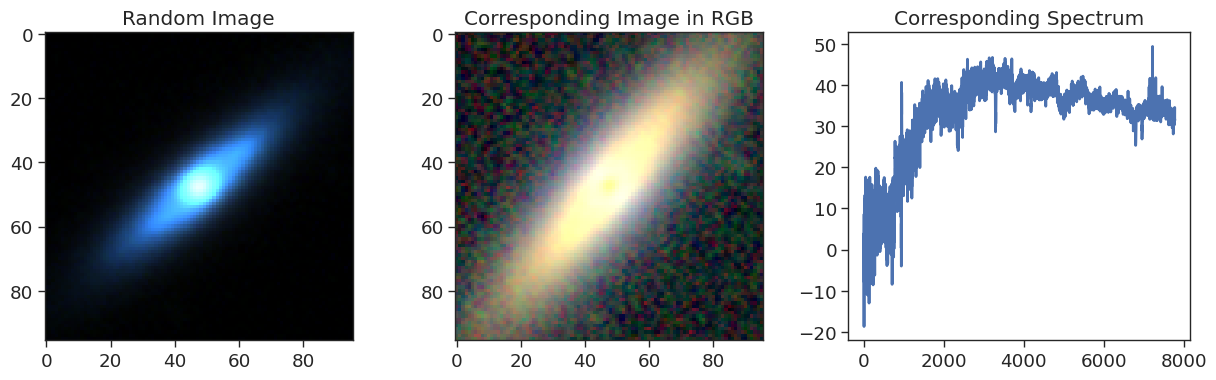

In [5]:
random_index = np.random.randint(len(dataset))
random_img, random_spec = image_transforms(dataset['train'][random_index]['image'].T).T, dataset['train'][random_index]['spectrum']

figure(figsize=(15, 4))

subplot(1, 3, 1)
imshow(random_img)
title('Random Image')

subplot(1, 3, 2)
imshow(dr2_rgb(random_img.T, bands=['g', 'r', 'z']))
title('Corresponding Image in RGB')

subplot(1, 3, 3)
plot(random_spec)
title('Corresponding Spectrum')

# Image Embedder

We use the pretrained galaxy image encoder from Stein et al., 2021. This model is based on MoCo V2 (Chen et al., 2020), and uses a ResNet50 backbone as the encoder. The model is pretrained in a self-supervised regime, using augmented pairs of galaxies that have undergone a variety of augmentations, including galactic extinction, rotation, size scaling, point-spread function blur, jittering and cropping, and Gaussian noise. Pretraining is performed on a curated subset of 3.5 million galaxies sampled uniformly by z-band magnitude from the the DESI Legacy Survey. This model has 28M parameters in total, during our contrastive training phase, we keep the convolutional part of the model frozen and only finetune the dense final layers which amount to 4.5M  parameters.

In [21]:
class OutputExtractor(L.LightningModule):
    """
    Pass data through network to extract model outputs
    """
    def __init__(self, backbone: torch.nn.Module):    
        super(OutputExtractor, self).__init__()
        self.backbone = backbone
        self.backbone.eval()

    def forward(self, batch):
        x, _ = batch
        z_emb = self.backbone(x)
        return z_emb
    
    def predict(self, batch, batch_idx: int, dataloader_idx: int=None):
        return self(batch)

# Extract encoder_q from Moco_v2 model
moco_model = Moco_v2.load_from_checkpoint(checkpoint_path='/mnt/ceph/users/flanusse/resnet50.ckpt')
backbone = moco_model.encoder_q
img_model = OutputExtractor(backbone).to('cuda')

num_params = np.sum(np.fromiter((p.numel() for p in img_model.parameters()), int))
print(f"Number of parameters in image model: {num_params:,}")

Lightning automatically upgraded your loaded checkpoint from v1.6.2 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../ceph/users/flanusse/resnet50.ckpt`


Number of parameters in image model: 27,966,656


# Spectrum Embedder
As our architecture for the spectrum embedder, we adopt a transformer model structured similarly to  GPT-2. We pretrain this transformer only on spectra first, using a self-supervised learning paradigm. We randomly replace 6 contiguous segments of length 30 (equivalent to length 600 in the original spectra representation) with zeros and train the model to minimize the Mean Square Error loss between the predictions and the ground truth on the replaced segments of the sequence.

Once this mask-filling model has been trained, we freeze its weights and use a single cross-attention block (cross-attention layer with 4 heads and embedding dim 128 followed by an MLP) to extract a short embedding vector. We use the output of the final transformer block of the mask-filling model as the key and value and use a learnable sequence of size $1\times 128$ as the query vector. The output of this procedure is a single vector of length 128. The weights of this cross-attention block and the 128 parameters of the query vector amount to 362k total parameters which are then trained via the contrastive training training procedure described below.

### Load the Pretrained Spectrum Model
The pretrained model is saved in the Seqformer branch of Fi-LLM and can be loaded from there using the helper function load_model_from_ckpt

In [23]:
# The model is saved in the Seqformer branch of Fi-LLM
model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2708117"
out = load_model_from_ckpt(model_path)

config = out['config']
spec_model = out['model']

### Add a Decoder Head to the Pretrained Model
We add a simple decoder head to the pretrained spectrum model. As stated above, this decoder head uses a single cross-attention block to reduce the output of the mask-filling model to a 128 dimensional embedding. In total this model has 326K trainable parameters.

In [17]:
class seq_decoder(nn.Module):

    def __init__(self,  model, embed_dim=128, nhead=4, model_embed_dim=768, dropout=0.1):
        super().__init__()

        # The query of the spectrum transformer is set to a learnable 
        self.query = nn.Parameter(torch.randn(1, 1, embed_dim)) 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True, kdim=model_embed_dim, vdim=model_embed_dim)
        self.model = model
        
        # Freeze all of the weights of all of the intermediate layers of the pretraned Spectrum Transformer
        for param in self.model.parameters():
            param.requires_grad = False

        d_model = embed_dim
        dim_feedforward = 4 * d_model

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.GELU()

    def forward(self, sample, return_weights=False):
        sample=sample.unsqueeze(-1)
        batch_size = len(sample)
        
        # Embed the spectrum using the pretrained model 
        with torch.no_grad():
            embedding = self.model(fnc(sample))['embedding']
            
        # Perform single cross-attention on the embeddings
        attentions = self.multihead_attn(query=self.query.repeat(batch_size,1,1), key=embedding, value=embedding, need_weights=return_weights, average_attn_weights = False)
        x = self.norm(self.dropout1(attentions[0]))
        
        # Small MLP head 
        x = x+self.dropout2(self.linear2(self.dropout(self.activation(self.linear1(x)))))
        
        # Return weights option (for attention mask)
        if return_weights:
            return x.squeeze(), attentions[1]
        
        return x.squeeze()


# Modify the forward to output all of the embeddings
spec_model.forward = forward.__get__(spec_model, type(img_model))

# Add the decoder to the spectrum transformer
my_decoder = seq_decoder(model=spec_model)      

num_params = np.sum(np.fromiter((p.numel() for p in my_decoder.parameters()), int))
print(f"Number of parameters in spectrum model: {num_params:,}")

Number of parameters in spectrum model: 43,539,734


# Contrastive Objective

Let $\mathbf{im} \in \mathbb{R}^{N\times N}$ and $\mathbf{sp} \in \mathbb{R}^M$ be the image and spectrum of a galaxy, repsectively. Also, let $f^{im}_\theta: \mathbb{R}^{N \times N} \rightarrow \mathbb{R}^d$ and $f^{sp}_\theta: \mathbb{R}^M \rightarrow \mathbb{R}^d$ be the previously defined image and spectrum embedders that project the galaxy measurement into a shared $d$-dimensional space. We aim to construct a loss that maximizes the shared mutual information $I(f_\theta( \mathbf{x}), f_\theta(\mathbf{y}))$. To that end, we employ contrastive training under an InfoNCE loss, where we consider that both modalities represent  noisy views of the same underlying physical object. This loss is given by

\begin{equation}
    \mathcal{L}(\mathbf{im}, \mathbf{sp}, \tau) = - \sum_{i} \log \frac{\exp(f^{im}_\theta(\mathbf{im}_i)^t f^{sp}_\theta(\mathbf{sp}_i) / \tau)}{\exp(f^{im}_\theta(\mathbf{im}_i)^t f^{sp}_\theta(\mathbf{sp}_i) / \tau) + \sum_{i \neq j}   \exp(f^{im}_\theta(\mathbf{im}_i)^t f^{sp}_\theta(\mathbf{sp}_j) / \tau)} \;,
    \label{eq:infonce}
\end{equation}

where $\tau$ represents a smoothing parameter (sometimes referred to as temperature) and $j$ represent the indices of negative examples, not associated with the particular object $i$.



In [25]:
class CLIPLoss(nn.Module):
    def get_logits(self, image_features, spectrum_features, logit_scale):
        image_features = F.normalize(image_features, dim=-1, eps=1e-3)
        spectrum_features = F.normalize(spectrum_features, dim=-1, eps=1e-3)
        logits_per_image = logit_scale * image_features @ spectrum_features.T
        return logits_per_image, logits_per_image.T

    def forward(self, image_features, spectrum_features, logit_scale, output_dict=False):
        logits_per_image, logits_per_spectrum = self.get_logits(image_features, spectrum_features, logit_scale)
        labels = torch.arange(logits_per_image.shape[0], device=image_features.device, dtype=torch.long)
        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_spectrum, labels)
        ) / 2
        return {"contrastive_loss": total_loss} if output_dict else total_loss

# CLIP Training
The pretrained models are frozen and fed into our unified AstroCLIP model. We unfreeze the fully connected layers of the pretrained image encoder and attach an additional trainable single-layer, four-head transformer to the pretrained spectrum encoder. We set the queue length to $K = 512$ image-spectrum pairs, and perform basic data augmentation with random vertical and horizontal flips, random rotationson the images.

### Define the image and spectrum encoders
These are taken from pretrained image and spectrum encoders that are loaded in above.

In [27]:
# Define image and spectrum encoders
image_encoder = img_model
spectrum_encoder = seq_decoder(model=spec_model)   

num_params_im = sum(p.numel() for p in image_encoder.parameters())
num_params_sp = sum(p.numel() for p in my_decoder.parameters())
print(f"Image Encoder Params: {round(num_params_im/1e6, 1)} M, Spectrum Encoder Params: {round(num_params_sp/1e6, 1)} M")

Image Encoder Params: 28.0 M, Spectrum Encoder Params: 43.5 M


### Define the AstroCLIP model!
The AstroCLIP model simply loads in the pretrained models, freezing all but the last layers in the image encoder and all but the decoder head in the spectrum encoder. The model is then trained using the CLIP loss specified above.

In [33]:
class AstroCLIP(L.LightningModule):
    def __init__(self, image_encoder, spectrum_encoder):
        super().__init__()
        self.image_encoder = image_encoder
        
        # Freeze all but the last layers of the image encoder
        for name, child in self.image_encoder.backbone.named_children():
            if name != 'fc':
                for param in child.parameters():
                    param.requires_grad = False

        # Spectrum encoder is already frozen, so simply load it in
        self.spectrum_encoder = spectrum_encoder
        
        # Logit scale is fixed to 15.5 and is not a learnable parameter
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(15.5))
        self.criterion = CLIPLoss()
        
    def forward(self, x, image=True, return_weights=False):
        if image:
            # Embed image
            embedding = self.image_encoder((x,None))
        else:
            # Embed spectrum
            embedding = self.spectrum_encoder(x, return_weights=return_weights)
        return embedding


    def training_step(self, batch, batch_idx):
        # Training_step defines the train loop. It is independent of forward
        im, sp = batch['image'].transpose(1,3), batch['spectrum'].squeeze()
        im = image_transforms(im)#.to('cuda')
        image_features = self.image_encoder((im, None))
        spectrum_features = self.spectrum_encoder(sp)
        
        loss_withlogit = self.criterion(image_features, spectrum_features, 15.5)
        self.log("train_loss_withlogit", loss_withlogit)
        loss_nologit = self.criterion(image_features, spectrum_features, 1)
        self.log("train_loss_nologit", loss_nologit)
        self.log("scale", self.logit_scale)
        return loss_withlogit

    def validation_step(self, batch, batch_idx):
        # Validation_step defines the validation loop. It is independent of forward
        im, sp = batch['image'].transpose(1,3), batch['spectrum'].squeeze()
        im = image_transforms(im)
        image_features = self.image_encoder((im, None))
        spectrum_features = self.spectrum_encoder(sp)
        val_loss_nologit = self.criterion(image_features, spectrum_features, 1)
        self.log("val_loss_nologit", val_loss_nologit)
        val_loss_withlogit = self.criterion(image_features, spectrum_features, 15.5)
        self.log("val_loss_withlogit", val_loss_withlogit)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5, weight_decay=0.2)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=5e-6)
        return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler': scheduler,
            'interval': 'epoch',  # or 'step' for step-wise updating
            'frequency': 1,  # how often to apply
        }
    }

CLIP = AstroCLIP(image_encoder, spectrum_encoder)

### Training
The actual training loop runs here, this will expor the run to a log folder connected to tensorboard in the directory that it is loaded in.  

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

trainer = L.Trainer(
                callbacks=[
                ModelCheckpoint(
                    every_n_epochs=1,
                    save_top_k=-1,
                )],
                )

trainer.fit(model=CLIP, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

### Embedding
Once trained, the model can be used to embed the entired dataset using the code below. These embeddings can then be used for a variety of downstream tasks which are demonstrated in the following section. 

In [ ]:
dataset.set_format(type='torch', columns=['image', 'spectrum', 'redshift'])
testdata = torch.utils.data.DataLoader(dataset['test'], batch_size=512, shuffle=False, num_workers=10)

from tqdm import tqdm
embeddings = []
images = []
redshifts = []
spectra = []
source_spec = []
for batch_test in tqdm(testdata):
    images.append(np.stack([clip(dr2_rgb(i.cpu().T, bands=['g', 'r', 'z']),0,1) for i in batch_test['image']] ,axis=0))
    spectra.append(CLIP(batch_test['spectrum'].squeeze().to('cuda'), False).detach().cpu().numpy())
    embeddings.append(CLIP(image_transforms(batch_test['image'].transpose(1,3).to('cuda'))).detach().cpu().numpy())
    redshifts.append(batch_test['redshift'])
    source_spec.append(batch_test['spectrum'])

# Load the embeddings from our paper

In [35]:
# Path to the embeddings prepared by the model
filename = '/mnt/home/sgolkar/ceph/saves/AC_saves/siavash_embeddings_rca1esyj.npz'

# Extracting information 
data = np.load(filename)
z = data['redshift']
image_features = data['image_features']
spectrum_features = data['spectrum_features']
images = data['images']
spectra = data['spectra']
targetid = data['targetid']

# Unsupervised Downstream Tasks
Once the model is trained and the galaxy images and spectra have been embedded, it is possible to visualize the embedding space and to perform both in-modality and cross-modality search. 

## Visualize the Embeddings
Using Principal Component Analysis, we extract the main axes of variations of the embedded data, and plot a subsample of the embeddings in the principal dimensions.

In [36]:
im_pca = PCA(n_components=4).fit_transform(image_features/np.linalg.norm(image_features, axis=-1, keepdims=True))
sp_pca = PCA(n_components=4).fit_transform(spectrum_features/np.linalg.norm(spectrum_features, axis=-1, keepdims=True))

### First 2 PCA dimensions
There seems to be strong organization of galaxy color! 

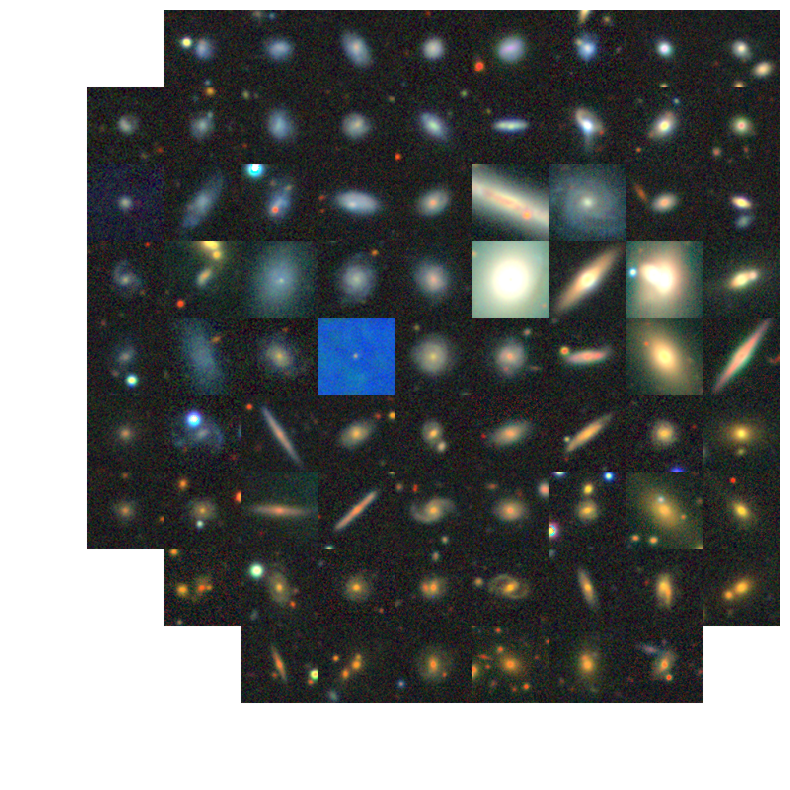

In [37]:
scatter_plot_as_images(im_pca, images, nx=10, ny=10);

## Testing Neighbor Retrieval

To visualize our embedding scheme's ability to align  representations of galaxies, we query galaxies and find the nearest neighbors in our embedding space using a cosine similarity search. For example, the cross-modal similarity $S_C(\mathbf{z}_i^{sp}, \mathbf{z}_j^{im})$ between a query spectrum $\mathbf{z}^{sp}_i = g_\theta(\mathbf{x}^{sp}_i)$ and an image $\mathbf{z}^{im}_j = f_\theta(\mathbf{x}^{im}_j)$ is given computed as:

\begin{equation}
    S_C (\mathbf{z}_i^{sp}, \mathbf{z}_j^{im}) = (\mathbf{z}^{sp}_i \cdot \mathbf{z}^{im}_j) / \parallel \mathbf{z}^{sp}_i \parallel \parallel \mathbf{z}^{im}_j \parallel 
\end{equation}


In [38]:
l = np.linspace(3586.7408577, 10372.89543574, spectra.shape[1])
ind_query = 80

In [39]:
# Compute the similarities across all of the other objects (for in-modality and cross-modality search)
image_features_normed = image_features / np.linalg.norm(image_features, axis=-1, keepdims=True)
spectrum_features_normed = spectrum_features / np.linalg.norm(spectrum_features, axis=-1, keepdims=True)

spectral_similarity = spectrum_features_normed[ind_query] @ spectrum_features_normed.T
image_similarity = image_features_normed[ind_query] @ image_features_normed.T
cross_image_similarity = image_features_normed[ind_query] @ spectrum_features_normed.T
cross_spectral_similarity = spectrum_features_normed[ind_query] @ image_features_normed.T
crop = CenterCrop(96)

(0.0, 20.0)

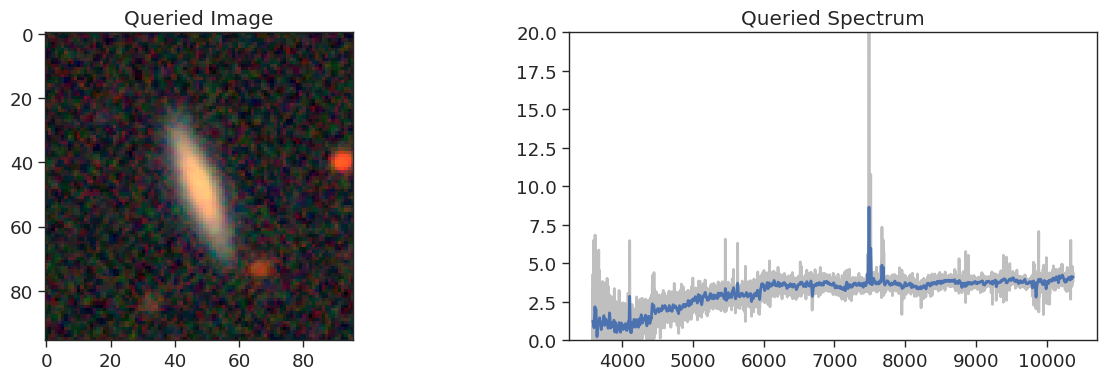

In [40]:
figure(figsize=[15,4])
subplot(121)
imshow(crop(torch.tensor(images[ind_query]).T).T)
title('Queried Image')
subplot(122)
plot(l,spectra[ind_query], color='grey', alpha=0.5)
plot(l,gaussian_filter1d(spectra[ind_query][:,0],5))
title('Queried Spectrum')
ylim(-0,20)

### Search with spectral similarity

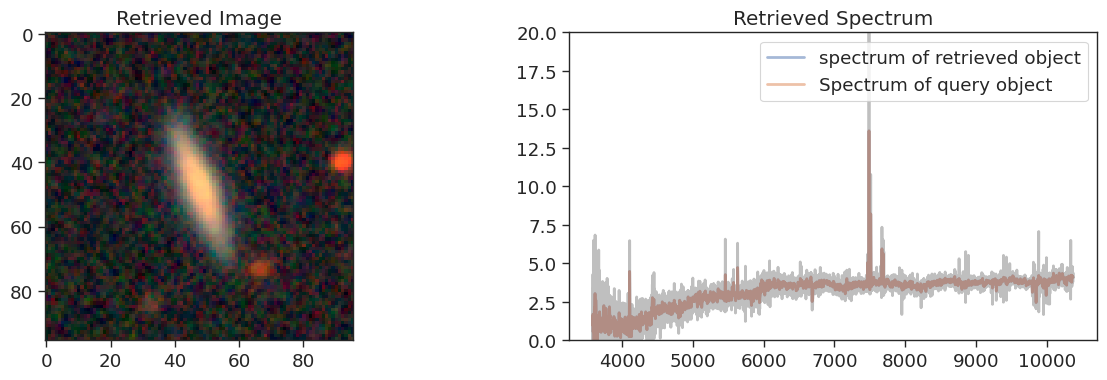

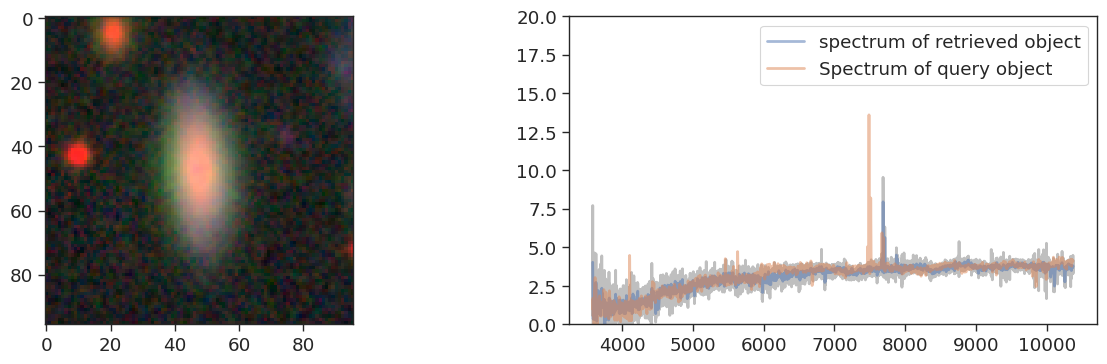

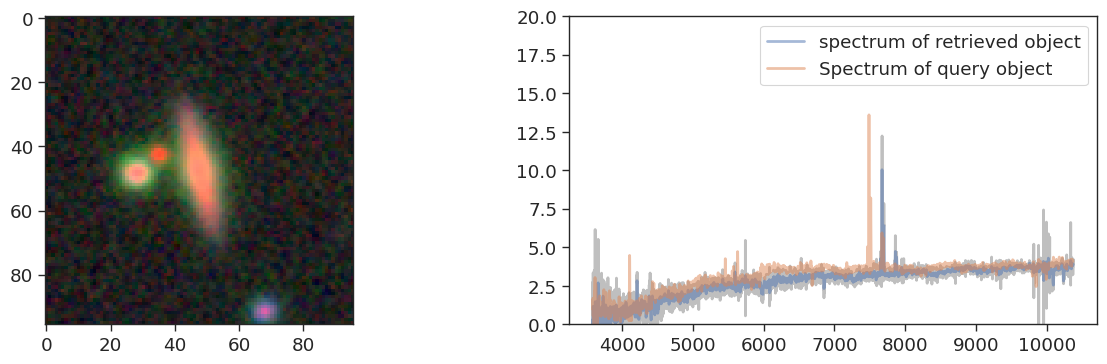

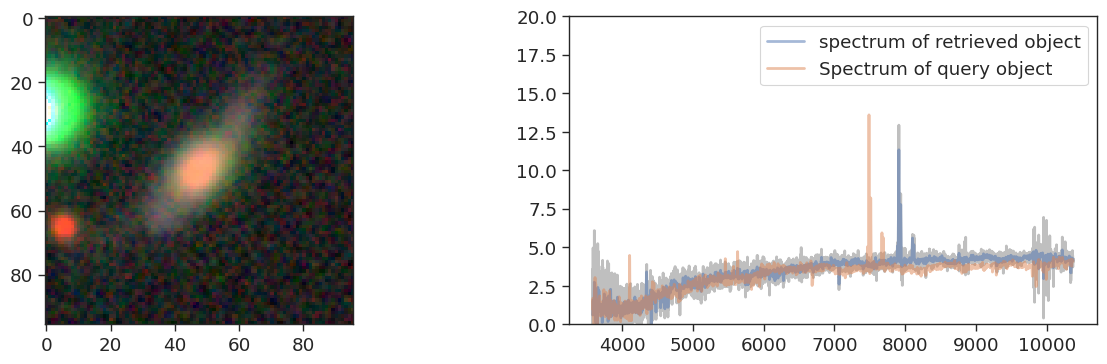

In [41]:
s = spectral_similarity
inds = argsort(s)[::-1]
for i in range(4):
    figure(figsize=[15,4])
    subplot(121)
    imshow(crop(torch.tensor(images[inds[i]]).T).T)
    if i == 0: title('Retrieved Image')
    subplot(122)
    plot(l,spectra[inds[i]], color='grey', alpha=0.5)
    plot(l,gaussian_filter1d(spectra[inds[i]][:,0],2),alpha=0.5, label='spectrum of retrieved object')
    plot(l,gaussian_filter1d(spectra[ind_query][:,0],2),alpha=0.5, label='Spectrum of query object')
    ylim(-0,20)
    if i == 0: title('Retrieved Spectrum')
    legend()

### Search with image similarity

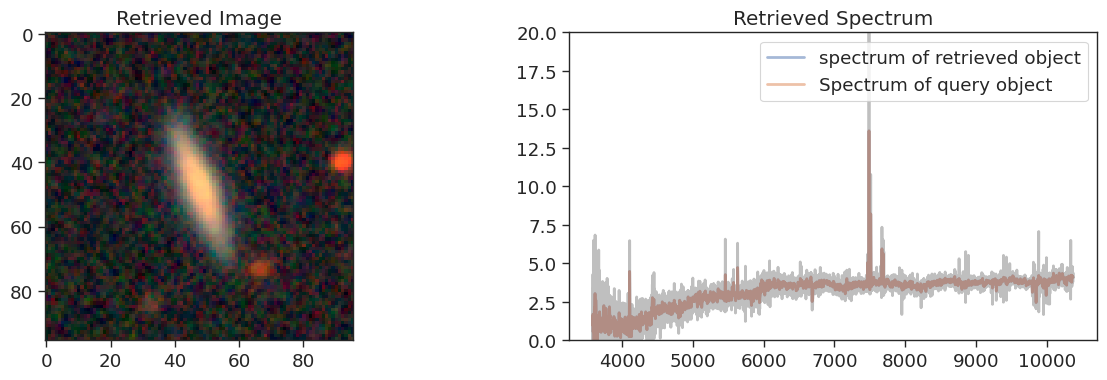

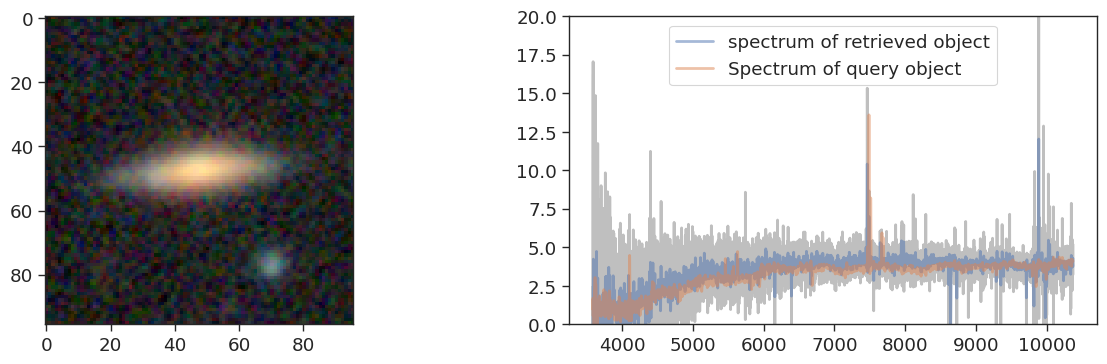

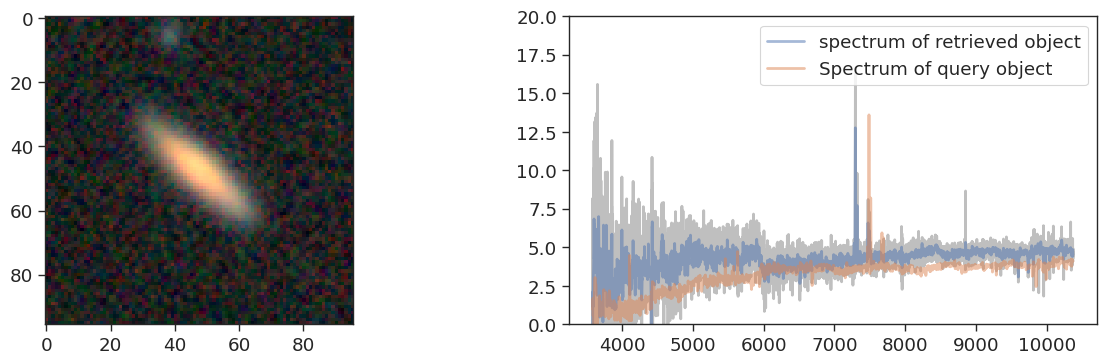

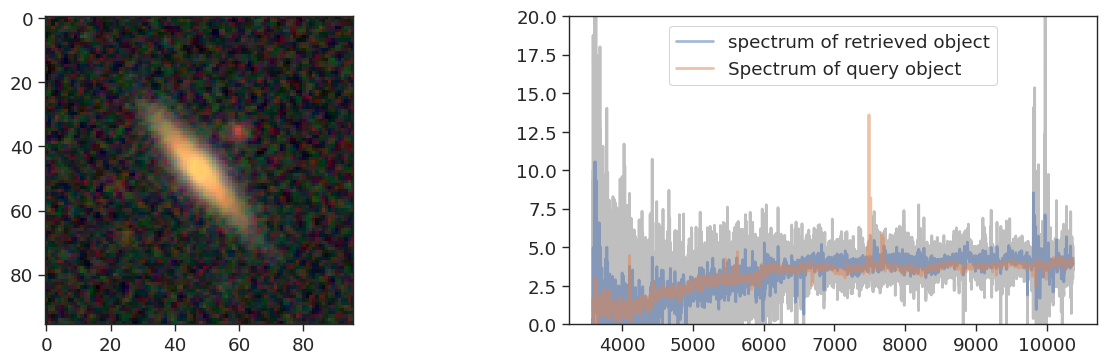

In [42]:
s = image_similarity
inds = argsort(s)[::-1]
for i in range(4):
    figure(figsize=[15,4])
    subplot(121)
    imshow(crop(torch.tensor(images[inds[i]]).T).T)
    if i == 0: title('Retrieved Image')
    subplot(122)
    plot(l,spectra[inds[i]], color='grey', alpha=0.5)
    plot(l,gaussian_filter1d(spectra[inds[i]][:,0],2),alpha=0.5, label='spectrum of retrieved object')
    plot(l,gaussian_filter1d(spectra[ind_query][:,0],2),alpha=0.5, label='Spectrum of query object')
    ylim(-0,20)
    if i == 0: title('Retrieved Spectrum')
    legend()

### Search with image-spectrum similarity

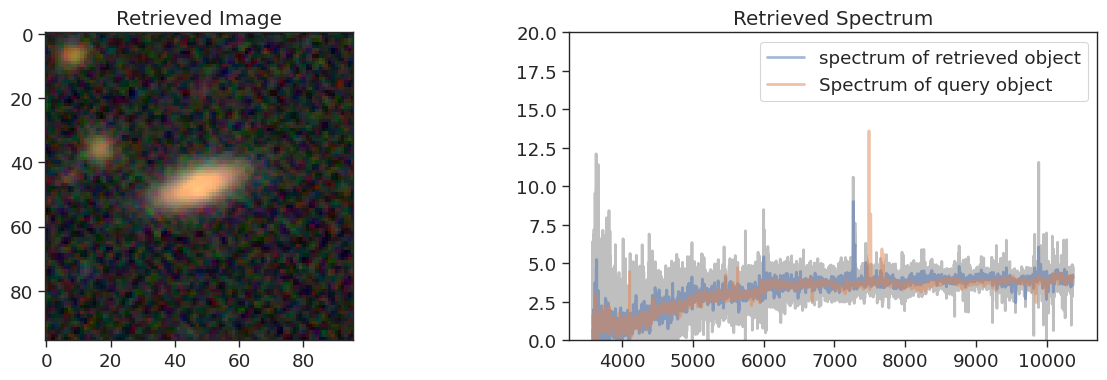

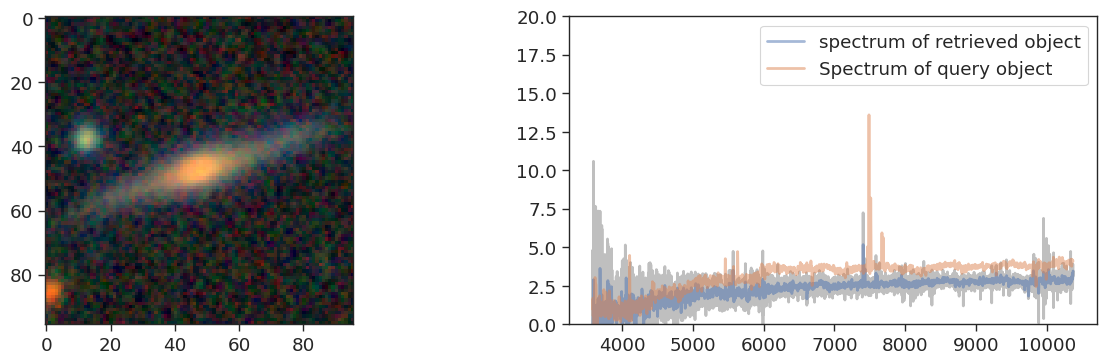

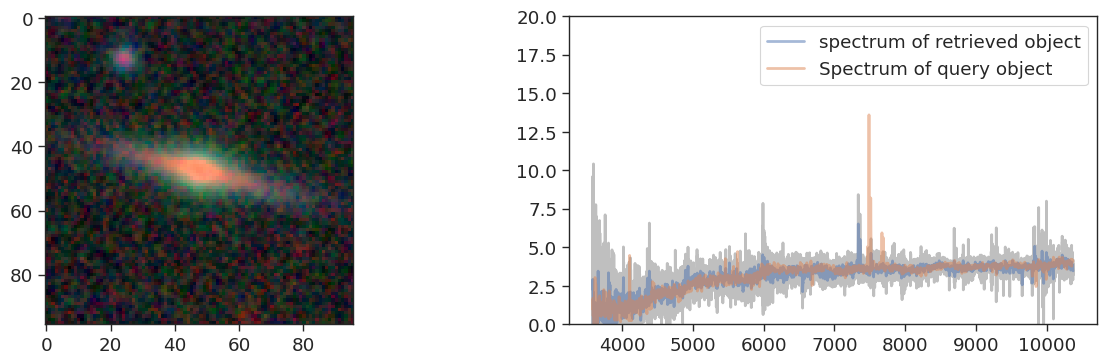

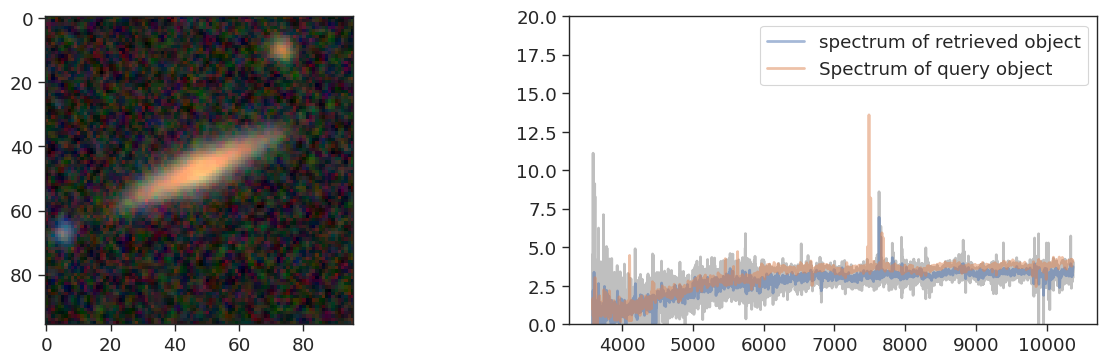

In [43]:
s = cross_image_similarity
inds = argsort(s)[::-1]
for i in range(4):
    figure(figsize=[15,4])
    subplot(121)
    imshow(crop(torch.tensor(images[inds[i]]).T).T)
    if i == 0: title('Retrieved Image')
    subplot(122)
    plot(l,spectra[inds[i]], color='grey', alpha=0.5)
    plot(l,gaussian_filter1d(spectra[inds[i]][:,0],2),alpha=0.5, label='spectrum of retrieved object')
    plot(l,gaussian_filter1d(spectra[ind_query][:,0],2),alpha=0.5, label='Spectrum of query object')
    ylim(-0,20)
    if i == 0: title('Retrieved Spectrum')
    legend()

### Search with spectrum-image similarity

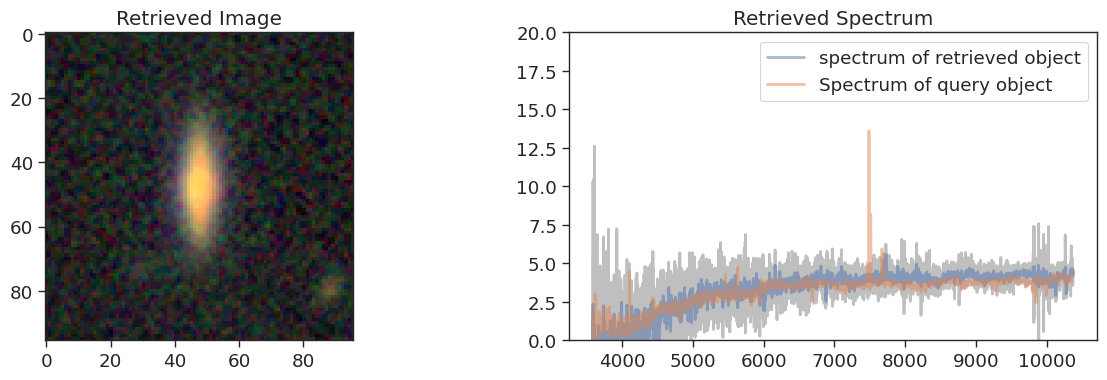

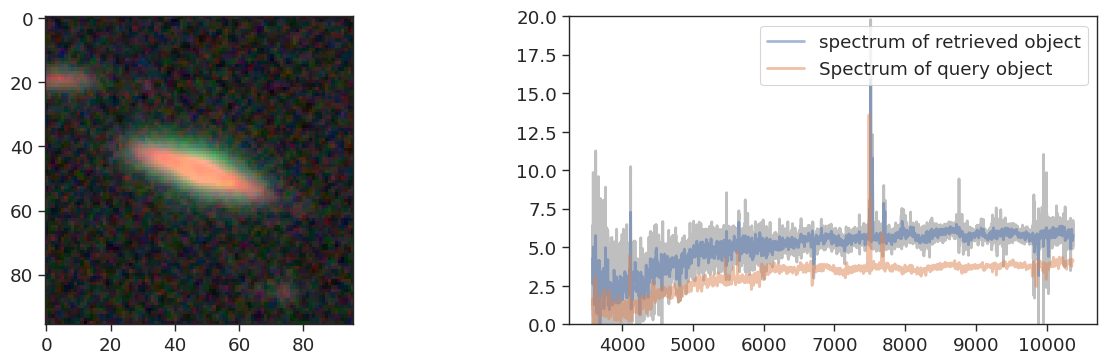

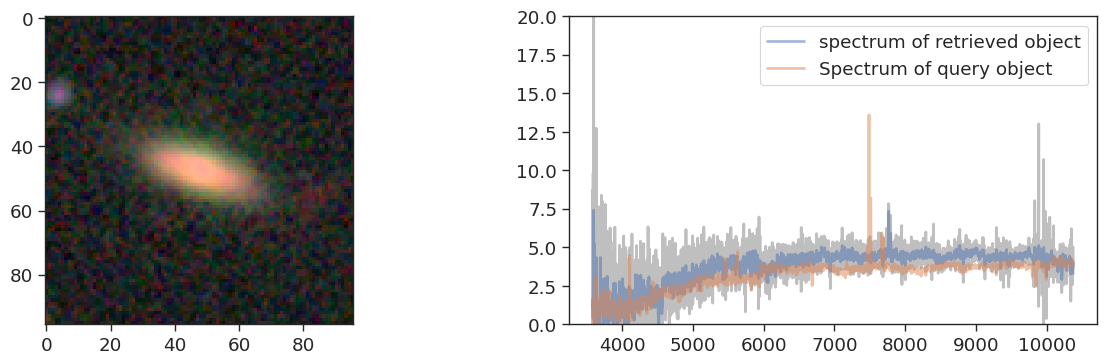

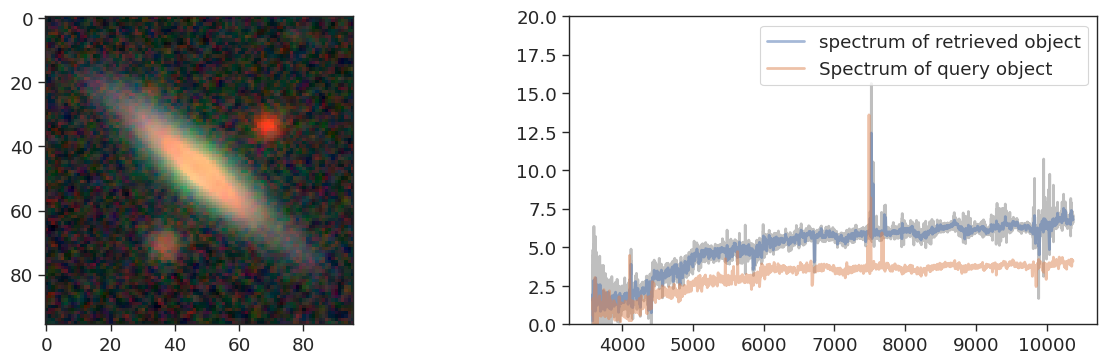

In [44]:
s = cross_spectral_similarity
inds = argsort(s)[::-1]
for i in range(4):
    figure(figsize=[15,4])
    subplot(121)
    imshow(crop(torch.tensor(images[inds[i]]).T).T)
    if i == 0: title('Retrieved Image')
    subplot(122)
    plot(l,spectra[inds[i]], color='grey', alpha=0.5)
    plot(l,gaussian_filter1d(spectra[inds[i]][:,0],2),alpha=0.5, label='spectrum of retrieved object')
    plot(l,gaussian_filter1d(spectra[ind_query][:,0],2),alpha=0.5, label='Spectrum of query object')
    ylim(-0,20)
    if i == 0: title('Retrieved Spectrum')
    legend()

# Supervised Downstream Tasks
In addition to performing unsupervised tasks, the compressed physical information in these embeddings can be used as a powerful prior for a variety of downstream tasks. Here, we demonstrate our model's ability to perform both accurate redshift and stellar mass estimation from the embedded representations in a zero-shot context, i.e. without the need to perform any further training. In particular, we use simple k-Nearest Neighbour (k-NN) regression of our embedded images and spectra to infer the particular redshift and the stellar mass of our galaxies. Specifically, k-NN regression is performed on the autocorrelated AstroCLIP image and spectrum embeddings, as well as on the correlated image-spectrum embeddings. 

## Read in galaxy properties

In [45]:
from astropy.table import Table, join

provabgs = Table.read('/mnt/home/flanusse/ceph/BGS_ANY_full.provabgs.sv3.v0.hdf5')

# Joining by target ids
embedding_table = Table({'targetid': targetid, 'image_features': image_features_normed, 'spectra_features': spectrum_features_normed})
provabgs = join(provabgs, embedding_table, keys_left='TARGETID', keys_right='targetid')

# Further removing spurious entries
provabgs = provabgs[(provabgs['PROVABGS_LOGMSTAR_BF'] > 0) * (provabgs['MAG_G'] > 0) * (provabgs['MAG_R'] > 0) * (provabgs['MAG_Z'] > 0)]

# Randomizing order to make sure we are fair
inds = np.random.permutation(len(provabgs))
provabgs = provabgs[inds]

## Zero-Shot Stellar Mass Prediction

### From Image Embeddings

In [46]:
neigh = KNeighborsRegressor(weights='distance', n_neighbors=16)
neigh.fit(provabgs['image_features'][:-5000], provabgs['PROVABGS_LOGMSTAR_BF'][:-5000])
preds = neigh.predict(provabgs['image_features'][-5000:])

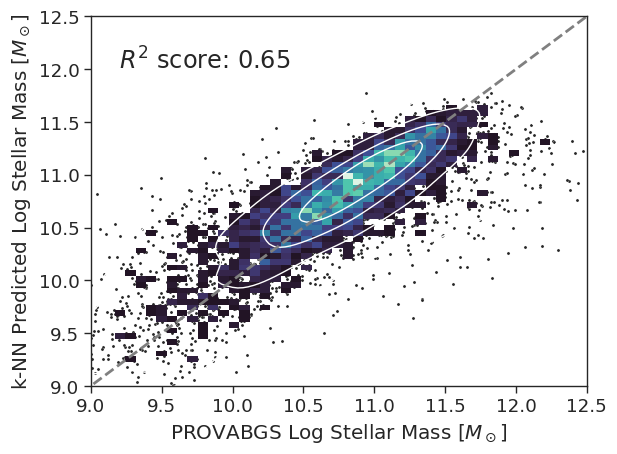

In [47]:
sns.scatterplot(x=provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], y=preds, s=5, color=".15")
sns.histplot(x=clip(provabgs['PROVABGS_LOGMSTAR_BF'][-5000:],8,13), y=clip(preds,8,13), bins=64, pthresh=.1, cmap="mako")
sns.kdeplot(x=provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], y=preds, levels=5, color="w", linewidths=1)
xlabel('PROVABGS Log Stellar Mass $[M_\odot]$')
ylabel('k-NN Predicted Log Stellar Mass $[M_\odot]$')
plot([8,13], [8,13], color='gray', ls='--')
xlim(9,12.5)
ylim(9,12.5)
text(9.2, 12, '$R^2$ score: %0.2f'%(r2_score(provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], preds)), fontsize='large' )
savefig('m_pred_im_embeddings.pdf', bbox_inches = 'tight', pad_inches = 0)

### From Spectrum Embeddings

In [48]:
neigh = KNeighborsRegressor(weights='distance', n_neighbors=16)
neigh.fit(provabgs['spectra_features'][:-5000], provabgs['PROVABGS_LOGMSTAR_BF'][:-5000])
preds = neigh.predict(provabgs['spectra_features'][-5000:])

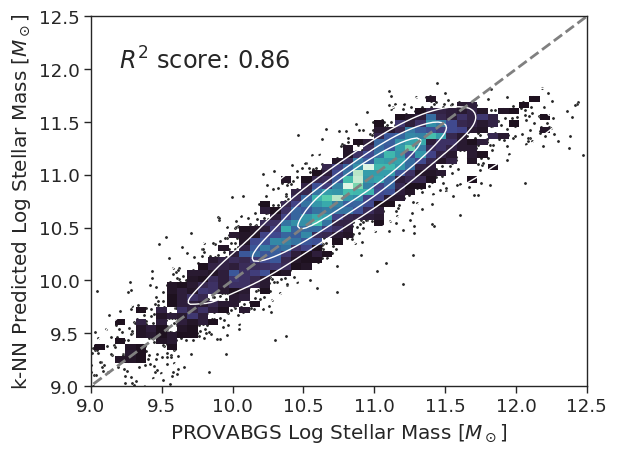

In [49]:
sns.scatterplot(x=provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], y=preds, s=5, color=".15")
sns.histplot(x=clip(provabgs['PROVABGS_LOGMSTAR_BF'][-5000:],8,13), y=clip(preds,8,13), bins=64, pthresh=.1, cmap="mako")
sns.kdeplot(x=provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], y=preds, levels=5, color="w", linewidths=1)
xlabel('PROVABGS Log Stellar Mass $[M_\odot]$')
ylabel('k-NN Predicted Log Stellar Mass $[M_\odot]$')
plot([8,13], [8,13], color='gray', ls='--')
xlim(9,12.5)
ylim(9,12.5)
text(9.2, 12, '$R^2$ score: %0.2f'%(r2_score(provabgs['PROVABGS_LOGMSTAR_BF'][-5000:], preds)), fontsize='large' )
savefig('m_pred_sp_embeddings.pdf', bbox_inches = 'tight', pad_inches = 0)

## Zero-Shot Redshift Prediction

### From Images

In [50]:
neigh = KNeighborsRegressor(weights='distance', n_neighbors=16)
neigh.fit(provabgs['image_features'][:-5000], provabgs['Z_HP'][:-5000])
preds = neigh.predict(provabgs['image_features'][-5000:])

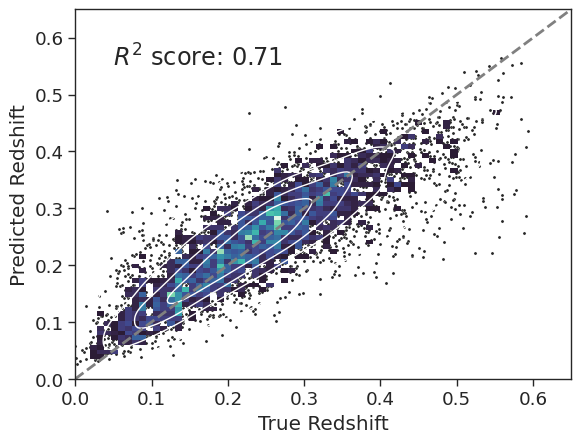

In [51]:
sns.scatterplot(x=provabgs['Z_HP'][-5000:], y=preds, s=5, color=".15")
sns.histplot(x=provabgs['Z_HP'][-5000:], y=preds, bins=64, pthresh=.1, cmap="mako")
sns.kdeplot(x=provabgs['Z_HP'][-5000:], y=preds, levels=5, color="w", linewidths=1)
xlabel('True Redshift')
ylabel('Predicted Redshift')
plot([0,1], [0,1], color='gray', ls='--')
xlim(0,0.65)
ylim(0,0.65)
text(0.05, 0.55, '$R^2$ score: %0.2f'%(r2_score(provabgs['Z_HP'][-5000:], preds)), fontsize='large' )
savefig('z_pred_im_embeddings.pdf', bbox_inches = 'tight', pad_inches = 0)

### From Spectra Embeddings

In [52]:
neigh = KNeighborsRegressor(weights='distance', n_neighbors=16)
neigh.fit(provabgs['spectra_features'][:-5000], provabgs['Z_HP'][:-5000])
preds = neigh.predict(provabgs['spectra_features'][-5000:])

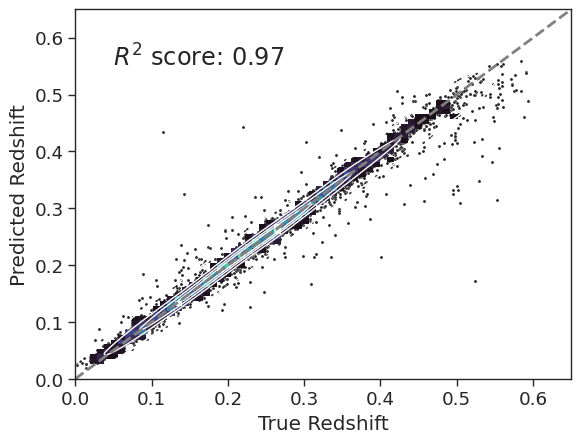

In [53]:
sns.scatterplot(x=provabgs['Z_HP'][-5000:], y=preds, s=5, color=".15")
sns.histplot(x=provabgs['Z_HP'][-5000:], y=preds, bins=64, pthresh=.1, cmap="mako")
sns.kdeplot(x=provabgs['Z_HP'][-5000:], y=preds, levels=5, color="w", linewidths=1)
xlabel('True Redshift')
ylabel('Predicted Redshift')
plot([0,1], [0,1], color='gray', ls='--')
xlim(0,0.65)
ylim(0,0.65)
text(0.05, 0.55, '$R^2$ score: %0.2f'%(r2_score(provabgs['Z_HP'][-5000:], preds)), fontsize='large' )
savefig('z_pred_sp_embeddings.pdf', bbox_inches = 'tight', pad_inches = 0)